In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from utils import mnist

In [45]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CUDA = False
SEED = 1
BATCH_SIZE = 32
LOG_INTERVAL = 200
EPOCHS = 10

In [3]:
ZDIMS = 2

In [4]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [5]:
# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

In [4]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [37]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 501)
        #self.relu = nn.ReLU()
        self.fc31 = nn.Linear(501, ZDIMS)  # mu layer
        self.fc32 = nn.Linear(501, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc4 = nn.Linear(ZDIMS, 500)
        self.fc5 = nn.Linear(500, 501)
        # from hidden 400 to 784 outputs
        self.fc6 = nn.Linear(501, 784)
       # self.sigmoid = nn.Sigmoid()

    def encode(self, x):

        # h1 is [128, 400]
        h = F.relu(self.fc1(x))  # type: Variable
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def reparameterize(self, mu, logvar):
       

        if self.training:
        
            #std = logvar.mul(0.5).exp_()  # type: Variable
            #eps = Variable(std.data.new(std.size()).normal_())
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)

        else:
            
            return mu

    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar


In [38]:
model = VAE()
#if CUDA:
 #   model.cuda()

In [39]:
def loss_function(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    #BCE = F.cross_entropy(recon_x, x.view(-1, 784))
   # print('BCE:', BCE)
    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print('KLD:', KLD)
    # Normalise by same number of elements as in reconstruction
   # KLD /= BATCH_SIZE * 784
    #print('KLD2:', KLD)
    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [40]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [41]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        #if CUDA:
         #   data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, z, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        #train_loss += loss.data[0]
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
                #loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset))) 
    


In [42]:
def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(valid_loader):
           # if CUDA:
            #    data = data.cuda()
            recon_batch, z, mu, logvar = model(data)
            # test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            #if i == 0:
             #  n = min(data.size(0), 8)
         # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          #  comparison = torch.cat([data[:n],
           #                       recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          #  save_image(comparison.data.cpu(),
          #           'results/reconstruction_' + str(epoch) + '.png', nrow=n)

   

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    early_stopping(test_loss, model)   

In [43]:
early_stopping = EarlyStopping(patience=EPOCHS, verbose=True)
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)
#model.load_state_dict(torch.load('checkpoint.pt'))
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.583398
Train Epoch: 1 [10000/60000 (20%)]	Loss: 178.237422
Train Epoch: 1 [20000/60000 (40%)]	Loss: 154.643359
Train Epoch: 1 [30000/60000 (60%)]	Loss: 168.721836
Train Epoch: 1 [40000/60000 (80%)]	Loss: 162.216162
====> Epoch: 1 Average loss: 142.8647
====> Test set loss: 157.4994
Validation loss decreased (inf --> 157.499427).  Saving model ...
Train Epoch: 2 [0/60000 (0%)]	Loss: 160.147285
Train Epoch: 2 [10000/60000 (20%)]	Loss: 159.631533
Train Epoch: 2 [20000/60000 (40%)]	Loss: 145.814639
Train Epoch: 2 [30000/60000 (60%)]	Loss: 160.805059
Train Epoch: 2 [40000/60000 (80%)]	Loss: 145.709443
====> Epoch: 2 Average loss: 128.6081
====> Test set loss: 150.3806
Validation loss decreased (157.499427 --> 150.380567).  Saving model ...
Train Epoch: 3 [0/60000 (0%)]	Loss: 154.935928
Train Epoch: 3 [10000/60000 (20%)]	Loss: 146.969834
Train Epoch: 3 [20000/60000 (40%)]	Loss: 151.224043
Train Epoch: 3 [30000/60000 (60%)]	Loss: 155.356738
Train Epoch:

In [32]:
model = VAE()
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()

VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=501, bias=True)
  (fc31): Linear(in_features=501, out_features=2, bias=True)
  (fc32): Linear(in_features=501, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=500, bias=True)
  (fc5): Linear(in_features=500, out_features=501, bias=True)
  (fc6): Linear(in_features=501, out_features=784, bias=True)
)

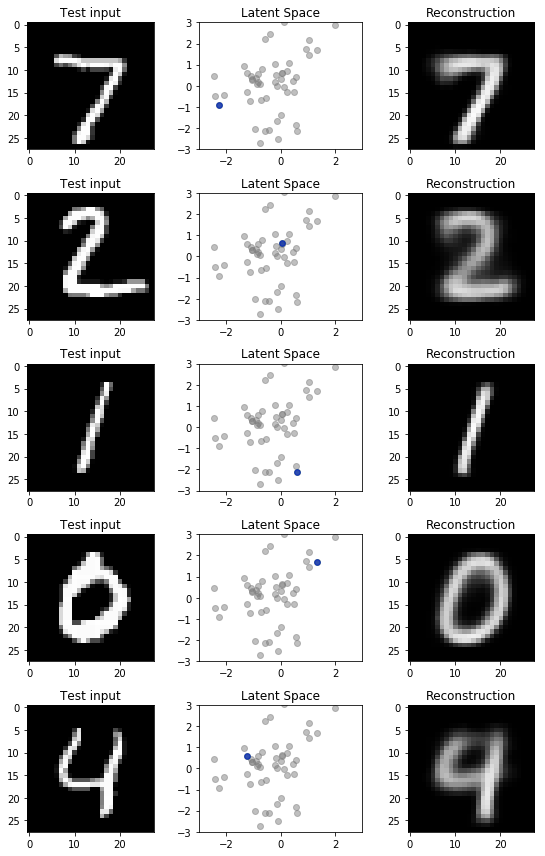

In [50]:
data, _ = next(iter(test_loader))
with torch.no_grad():
    x_reconstruct, z_vals, z_mean_val, z_log_sigma_sq_val  = model(data)
    plt.figure(figsize=(8,12))
    for i in range(5):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(data[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Test input")
        
        plt.subplot(5, 3, 3*i + 2)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=32, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=32, alpha=0.5)
       
        plt.xlim((-3,3))
        plt.ylim((-3,3))
        plt.title("Latent Space")
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Reconstruction")
        
    plt.tight_layout()    
    


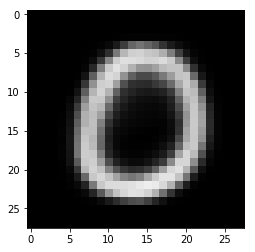

In [69]:
with torch.no_grad():
    d = torch.zeros([BATCH_SIZE,2])
    #d = np.zeros([BATCH_SIZE,2],dtype='float32')
    d[0] = torch.tensor([[1.,2.]])
    x_reconstruct = model.decode(d).cpu()
    plt.imshow(x_reconstruct[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))

In [ ]:
sample = Variable(torch.randn(32, ZDIMS))
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')
    

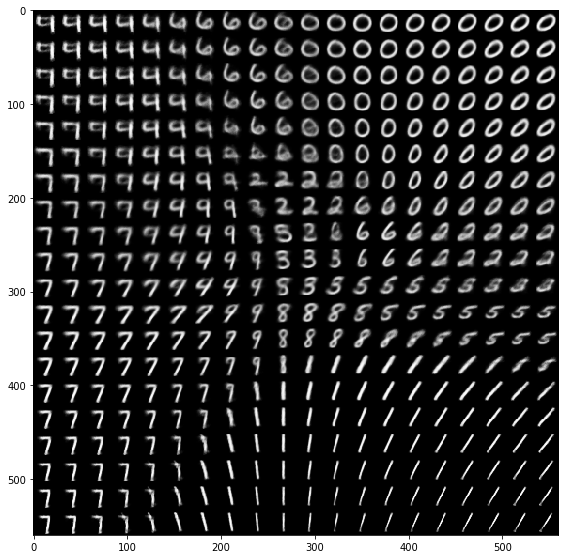

In [70]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
with torch.no_grad():
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = torch.tensor([[xi, yi]])
            d[0] = z_mu
            x_mean = model.decode(d).cpu()
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()